In [1]:
using RxInfer, Distributions, Random, GraphPlot, Cairo, MetaGraphsNext, GraphPPL, GraphViz, Dictionaries

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [3]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [4]:
conditioned = coin_model(a = 2.0, b = 7.0) | (y = [ true, false, true ], )

coin_model(a = 2.0, b = 7.0) conditioned on: 
  y = Bool[1, 0, 1]


In [7]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned)

ProbabilisticModel{GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}}(GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constv

In [9]:
gppl_model = RxInfer.getmodel(rxi_model)

GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0, GraphPPL.PluginsCollection{Tuple{}}(()), RxInfer.ReactiveMPGraphPPLBackend(), Base.RefValue{Int64}(12))

In [10]:
# Extract the MetaGraphsNext graph - we'll want to simply pass the GraphPPL.Model eventually 
meta_graph = gppl_model.graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

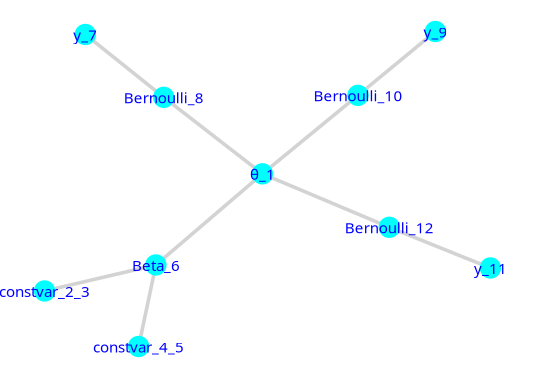

In [11]:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan",
)

# Querying The Structure of The Graph

## Contexts

After creating a GraphPPL.Model structure, it is important to know about the attached Context. The Context structure contains all variable and factor nodes in the scope of the model, and contains a Context stucture for all submodels. The context of a model can be accessed by the ```GraphPPL.getcontext()``` function:

In [12]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [13]:
gppl_model_context = GraphPPL.getcontext(gppl_model)

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


In [14]:
function gppl_global_context_info(model::GraphPPL.Model)
    
    context = GraphPPL.getcontext(model)
    
    println("Individual variables: ", context.individual_variables)
    println("Vector variables: ", context.vector_variables)
    println("Tensor variables: ", context.tensor_variables)
    println("Proxies: ", context.proxies)
    println("Factor nodes: ", context.factor_nodes)
    println("Depth: ", context.depth)
    println("Prefix: ", context.prefix)
    println("Parent: ", context.parent)
    println("Submodel counts: ", context.submodel_counts)
    println("Children: ", context.children)
    println("Returnval: ", context.returnval)
    println("------------------------------------- Factor Nodes -------------------------------------")
    
    for factor_node in context.factor_nodes
        node_data = model[factor_node]
        println("Factor Node: ", factor_node)
        println("  Form: ", node_data.properties.fform)
        println("  Neighbors:")
        for (label, edge, neighbor) in node_data.properties.neighbors
            println("    - Label: ", label)
            println("      Edge: ", edge)
            println("      Neighbor: ", neighbor)
            println("      Type of Neighbor: ", typeof(neighbor))
            println()
        end
    end
end

gppl_global_context_info (generic function with 1 method)

In [15]:
for (factor_ID, factor_label) in pairs(gppl_model_context.factor_nodes)
#     println("$(factor_ID), $(factor_label)")
#     println("$(typeof(factor_ID)), $(typeof(factor_label))")
    node_data = gppl_model[factor_label]
    println("node_data: $(node_data)\n")
end

node_data: NodeData in context  with properties fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_7, out, NodeData in context  with properties name = y, index = 1), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

node_data: NodeData in context  with properties fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_9, out, NodeData in context  with properties name = y, index = 2), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

node_data: NodeData in context  with properties fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_11, out, NodeData in context  with properties name = y, index = 3), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

node_data: NodeData in context  with properties fform = Beta, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.Nod

In [46]:
gppl_model_context.factor_nodes

4-element UnorderedDictionary{GraphPPL.FactorID, GraphPPL.NodeLabel}
 (Bernoulli, 1) │ Bernoulli_8
 (Bernoulli, 2) │ Bernoulli_10
 (Bernoulli, 3) │ Bernoulli_12
      (Beta, 1) │ Beta_6

# Inspecting The MetaGraph

In [96]:
meta_graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

In [53]:
meta_graph[]

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


In [67]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [121]:
methods(GraphPPL.NodeLabel)

# 2 methods for type constructor:
 [1] GraphPPL.NodeLabel(name, global_counter::Int64)
     @ ~/.julia/packages/GraphPPL/BYCRJ/src/graph_engine.jl:193
 [2] GraphPPL.NodeLabel(name, global_counter)
     @ ~/.julia/packages/GraphPPL/BYCRJ/src/graph_engine.jl:193

In [120]:
for label in collect(labels(meta_graph))
    println("$(label): $(typeof(label))")
#     println("$(meta_graph[label]): $(typeof(label.name))")
end

θ_1: GraphPPL.NodeLabel
constvar_2_3: GraphPPL.NodeLabel
constvar_4_5: GraphPPL.NodeLabel
Beta_6: GraphPPL.NodeLabel
y_7: GraphPPL.NodeLabel
Bernoulli_8: GraphPPL.NodeLabel
y_9: GraphPPL.NodeLabel
Bernoulli_10: GraphPPL.NodeLabel
y_11: GraphPPL.NodeLabel
Bernoulli_12: GraphPPL.NodeLabel


In [103]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [102]:
MetaGraphsNext.vertices(meta_graph)

Base.OneTo(10)

In [106]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [110]:
collect(edge_labels(meta_graph))

9-element Vector{Tuple{GraphPPL.NodeLabel, GraphPPL.NodeLabel}}:
 (θ_1, Beta_6)
 (θ_1, Bernoulli_8)
 (θ_1, Bernoulli_10)
 (θ_1, Bernoulli_12)
 (constvar_2_3, Beta_6)
 (constvar_4_5, Beta_6)
 (y_7, Bernoulli_8)
 (y_9, Bernoulli_10)
 (y_11, Bernoulli_12)

In [125]:
code_for(meta_graph, GraphPPL.NodeLabel(:θ_1, 1))

LoadError: KeyError: key θ_1_1 not found

In [115]:
MetaGraphsNext.edges(meta_graph)

SimpleEdgeIter 9

In [92]:
fieldnames(GraphPPL.NodeLabel)

(:name, :global_counter)

In [84]:
meta_graph[G]

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

In [54]:
typeof(meta_graph)

MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}

In [55]:
typeof(meta_graph[])

GraphPPL.Context

In [116]:
haskey(meta_graph, :θ_1)

false

# GraphViz Visualisations and DOT Code

In [21]:
function wrap_dot_code(dot_code::String)
    return "dot\"\"\"\n$dot_code\n\"\"\""
end

wrap_dot_code (generic function with 1 method)

In [107]:
function generate_dot_code(gppl_graph::GraphPPL.Model)
    
    graph = gppl_graph.graph
    
    dot_code = "digraph G {node [shape=circle];"

    for vertex in MetaGraphsNext.vertices(graph)
#     for vertex in keys(Meta_graph.vertex_properties)
        dot_code *= "    $vertex;"
    end

    for edge in MetaGraphsNext.edges(graph)
        dot_code *= "    $(edge.src) -> $(edge.dst);"
    end

    dot_code *= "}"
    
    wrapped_dot_code = wrap_dot_code(dot_code)
    
    return wrapped_dot_code
end

generate_dot_code (generic function with 1 method)

In [23]:
function gv_plot(gppl_graph::GraphPPL.Model)
    
#     dot_code = "digraph G {node [shape=circle];"
    dot_code = "graph G {node [shape=circle];"
    
    gppl_model_context = GraphPPL.getcontext(gppl_graph)

    for (indvar, label) in pairs(gppl_model_context.individual_variables)
        dot_code *= "    $indvar;"
    end

    for edge in MetaGraphsNext.edges(gppl_graph)
        dot_code *= "    $(edge.src) -- $(edge.dst);"
    end

    dot_code *= "}"
    
    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code))
end

gv_plot (generic function with 1 method)

In [126]:
#=
This is the current working example function
=#
function gv_plot_meta_graph(gppl_graph::GraphPPL.Model)
    
#     dot_code = "digraph G {node [shape=circle];"
    dot_code = "graph G {node [shape=circle];"
    
    gppl_model_context = GraphPPL.getcontext(gppl_graph)

    for vert_label in collect(labels(gppl_graph.graph))
        dot_code *= "    $vert_label;"
    end

#     for edge in MetaGraphsNext.edges(gppl_graph)
#         dot_code *= "    $(edge.src) -- $(edge.dst);"
#     end
    for edge_label in collect(edge_labels(gppl_graph.graph))
        dot_code *= "    $(edge_label.src) -- $(edge_label.dst);"
    end

    dot_code *= "}"
    
    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code))
end

LoadError: UndefVarError: `This` not defined

In [114]:
gv_plot_meta_graph(gppl_model)

LoadError: type Tuple has no field src

In [25]:
gppl_model_context

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


# Operating on the MetaGraph or the GraphPPL.Model?